# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

scanpy==1.3.7+86.g2c80c7a anndata==0.6.17+1.ga0cd0c6 numpy==1.14.6 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

In [3]:
adata = sc.datasets.paul15()

... 100%

... storing 'paul15_clusters' as categorical


In [4]:
adata

AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

Let us work with a higher precision than the default 'float32' to ensure _exactly_ the same results across different computational platforms.

In [5]:
adata.X = adata.X.astype('float64')  # this is not required and results will be comparable without it

## Preprocessing and Visualization

Apply a simple [preprocessing recipe](https://scanpy.readthedocs.io/en/latest/api/scanpy.api.pp.recipe_zheng17.html).

In [6]:
sc.pp.recipe_zheng17(adata)

Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 
Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


running recipe zheng17


Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 
Up to anndata 0.6.12, `.copy()` cast a non-'float32' `.X` to 'float32'. Now, the dtype 'float64' is maintained. 


    finished (0:00:00.49)


In [7]:
sc.tl.pca(adata, svd_solver='arpack')

In [8]:
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:02.65) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
drawing single-cell graph using layout "fa"
    finished (0:00:11.41) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


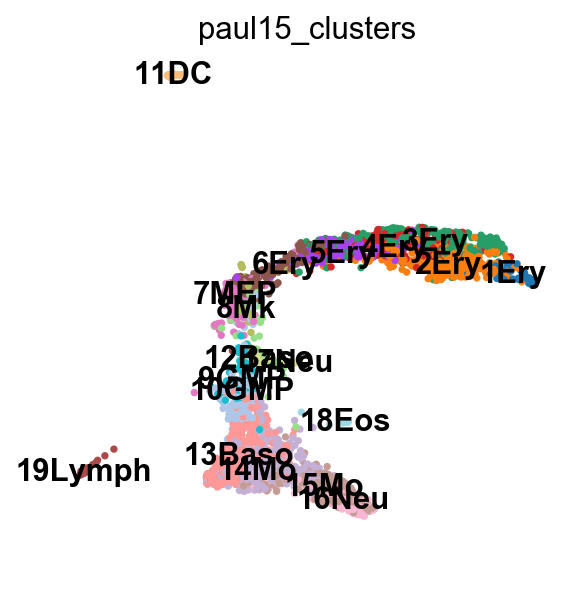

In [9]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This looks like a mess.

## Optional: Denoising the graph

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It's very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. [Schiebinger et al. (2017)](https://doi.org/10.1101/191056) or [Tabaka et al. (2018)](https://doi.org/10.1101/512582). It's also related to the principles behind MAGIC [Dijk et al. (2018)](https://doi.org/10.1016/j.cell.2018.05.061).

<div class="alert alert-info">

**Note**
    
This is *not* a necessary step, neither for PAGA, nor clustering, nor pseudotime estimation. You might just as well go ahead with a non-denoised graph. In many situations (also here), this will give you very decent results.
    
</div>  

In [10]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         0.9989278  0.99671    0.99430376 0.98939794
     0.9883687  0.98731077 0.9839871  0.983007   0.97908056 0.97625476
     0.9744365  0.9729161  0.9652972 ]
    finished (0:00:00.07) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing neighbors
    finished (0:00:00.46) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix


In [11]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout "fa"
    finished (0:00:10.23) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


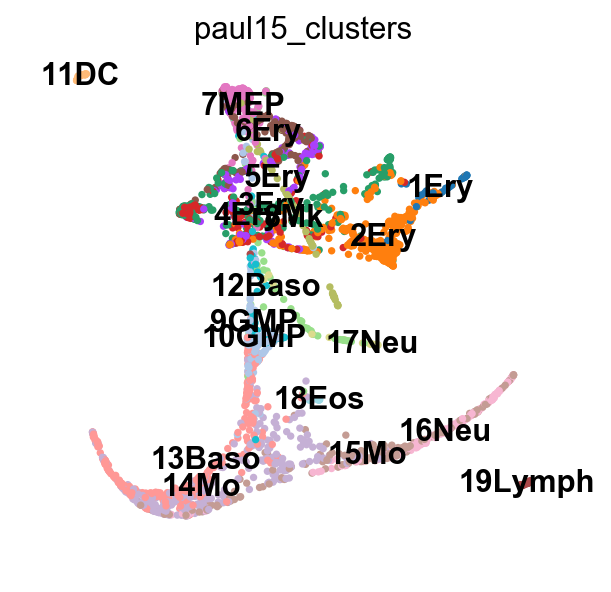

In [12]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

This still looks messy, but in a different way: a lot of the branches are overplotted.

## Clustering and PAGA

In [13]:
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.10) --> found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Annotate the clusters using marker genes.

| cell type | marker |
| --- | --- |
|HSCs | Procr |
|Erythroids | Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1 |
|Neutrophils | Elane, Cebpe, Ctsg, Mpo, Gfi1 |
|Monocytes | Irf8, Csf1r, Ctsg, Mpo |
|Megakaryocytes | Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf |
|Basophils | Mcpt8, Prss34 |
|B cells | Cd19, Vpreb2, Cd79a |
|Mast cells| Cma1, Gzmb, CD117/C-Kit |
|Mast cells & Basophils| Ms4a2, Fcer1a, Cpa3, CD203c (human)|

For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [14]:
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished (0:00:00.14) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


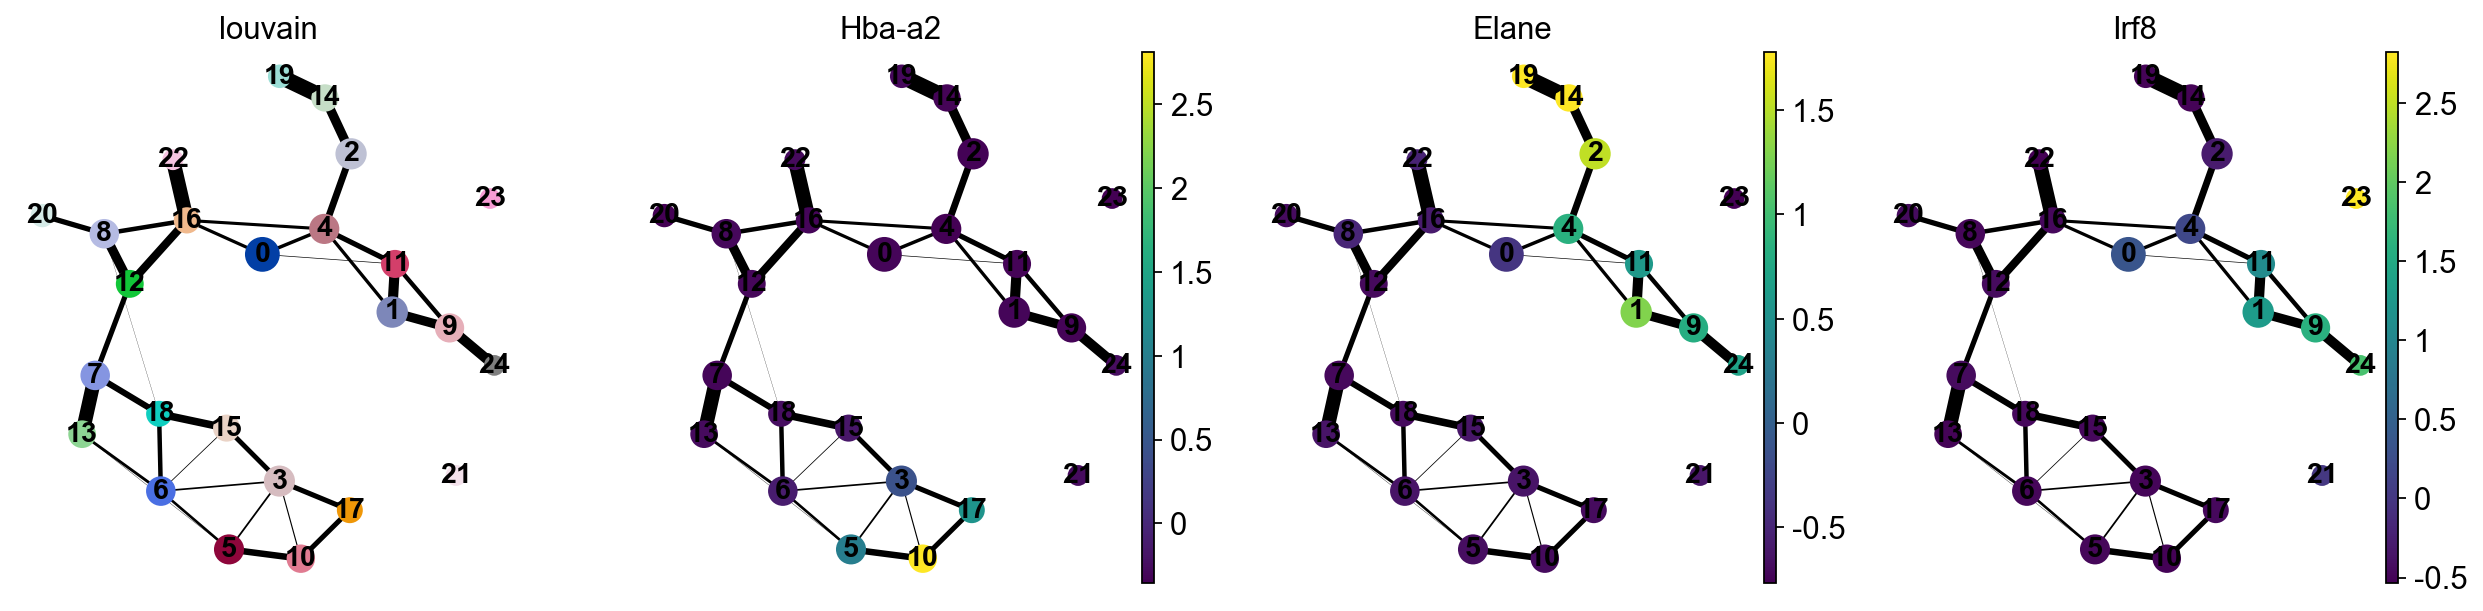

In [15]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

--> added 'pos', the PAGA positions (adata.uns['paga'])


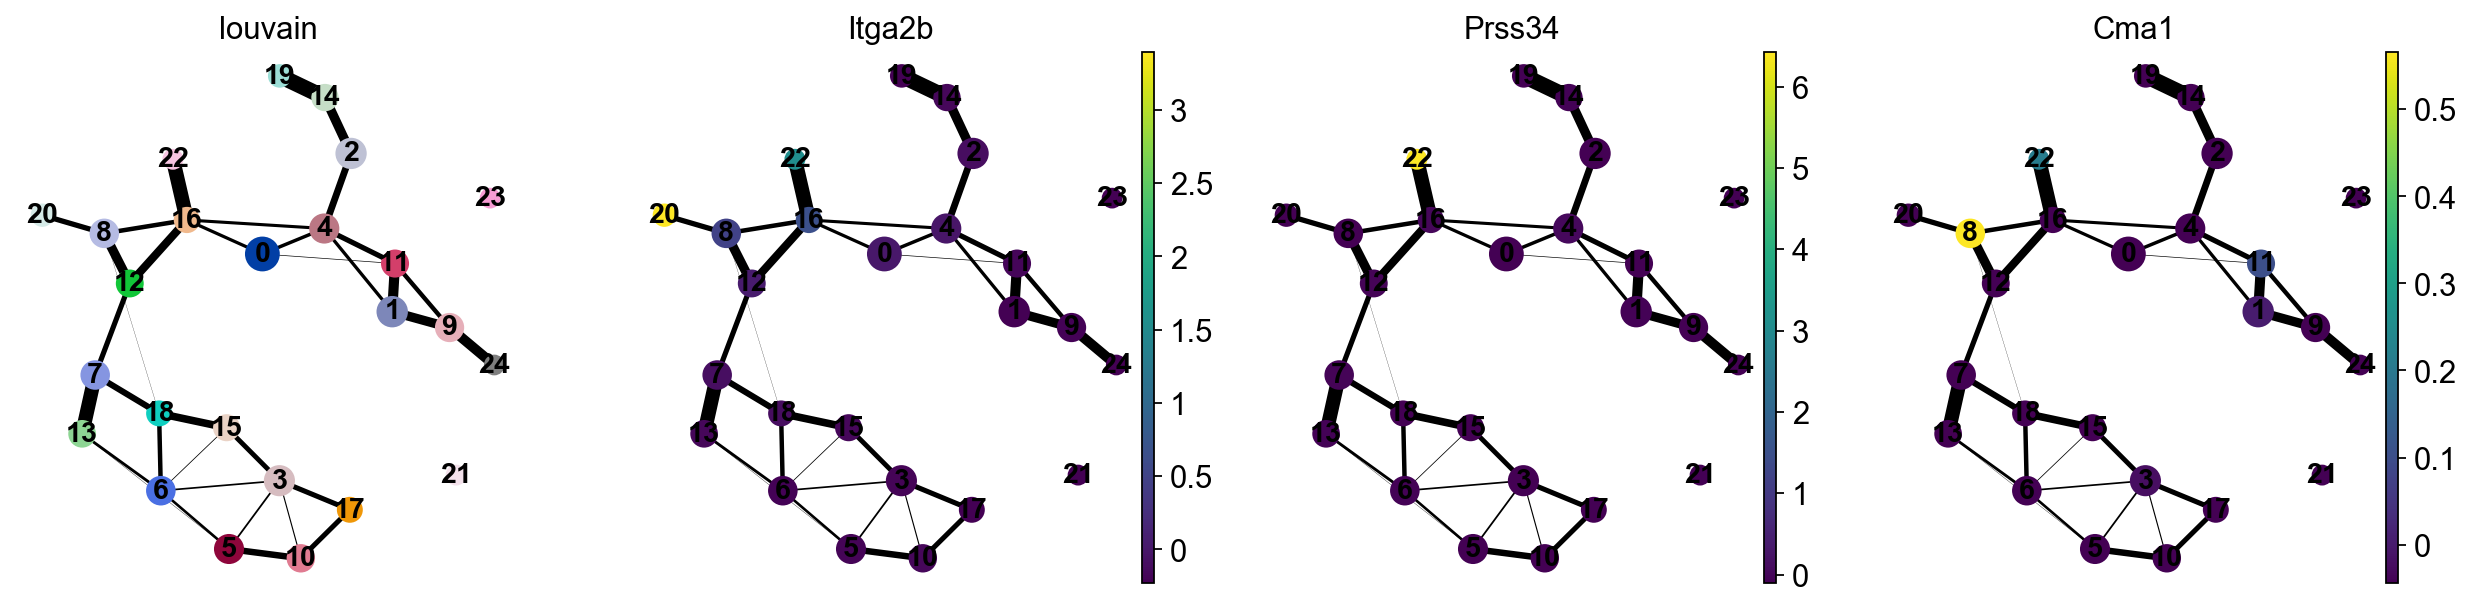

In [16]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

Actually annotate the clusters --- note that *Cma1* is a Mast cell marker and only appears in a small fraction of the cells in the progenitor/stem cell cluster 8, see the single-cell resolved plot below.

In [17]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [18]:
adata.obs['louvain_anno'] = adata.obs['louvain']

In [19]:
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10/Ery', '11', '12',
       '13', '14', '15', '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

Let's use the annotated clusters for PAGA.

In [20]:
sc.tl.paga(adata, groups='louvain_anno')

running PAGA
    finished (0:00:00.11) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)


--> added 'pos', the PAGA positions (adata.uns['paga'])


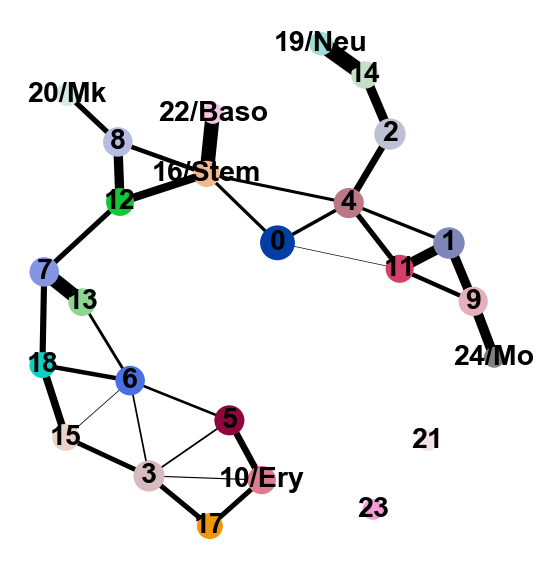

In [21]:
sc.pl.paga(adata, threshold=0.03)

## Recomputing the embedding using PAGA-initialization

The following is just as well possible for a UMAP.

In [22]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout "fa"
    finished (0:00:09.98) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


Now we can see all marker genes also at single-cell resolution in a meaningful layout.

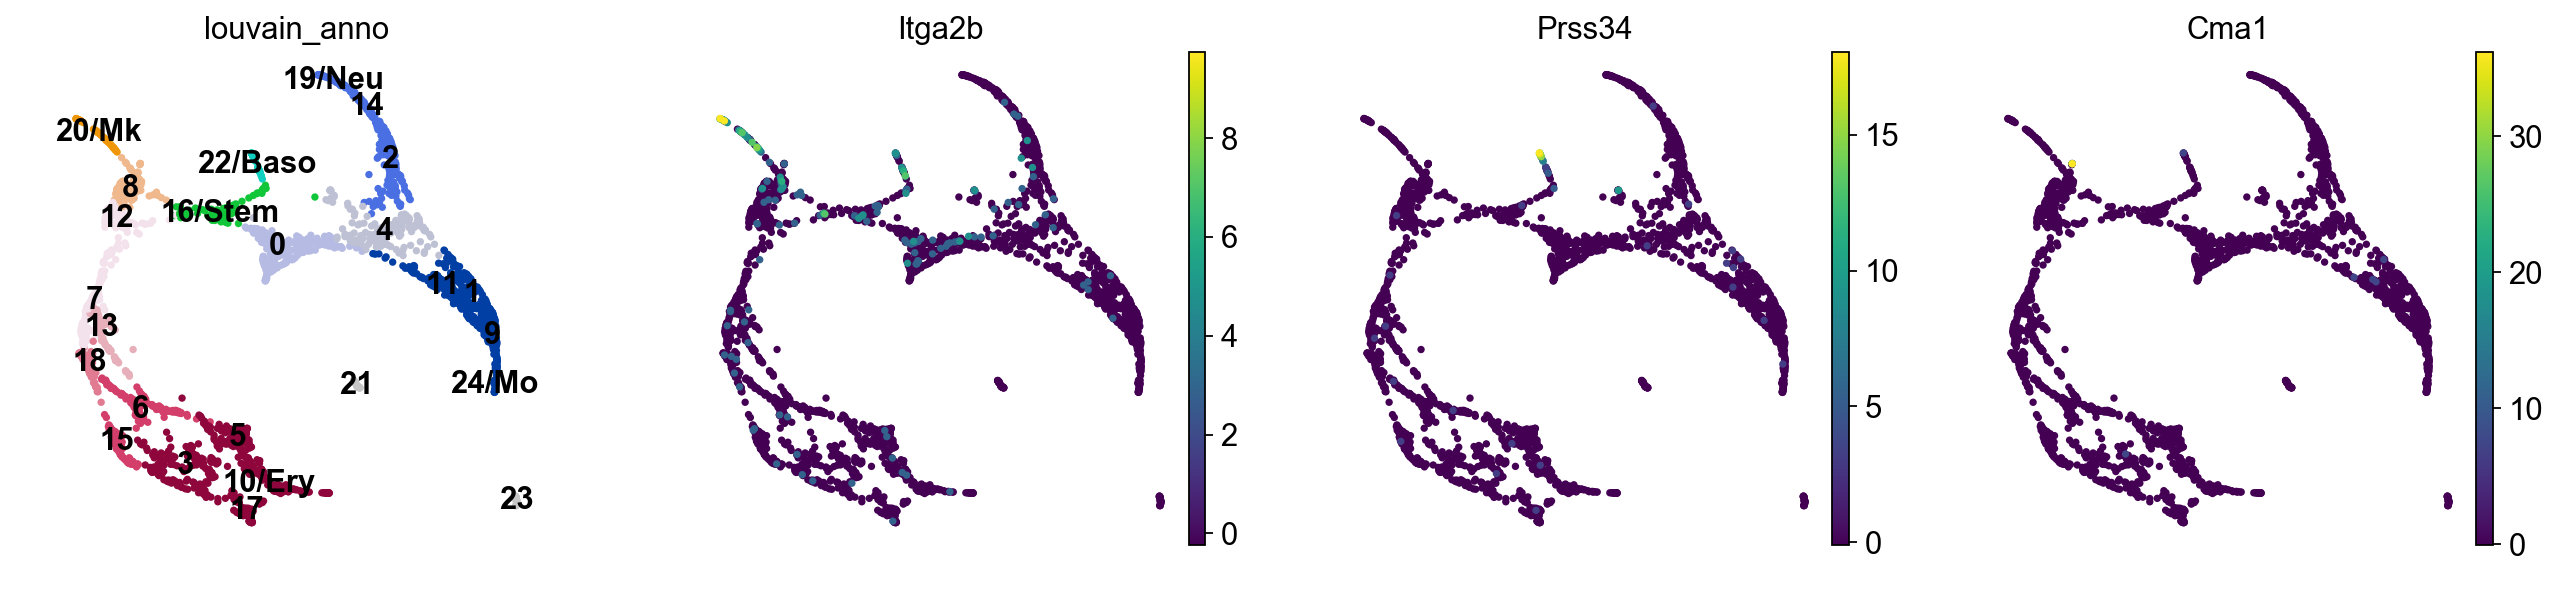

In [41]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

Choose the colors of the clusters a bit more consistently.

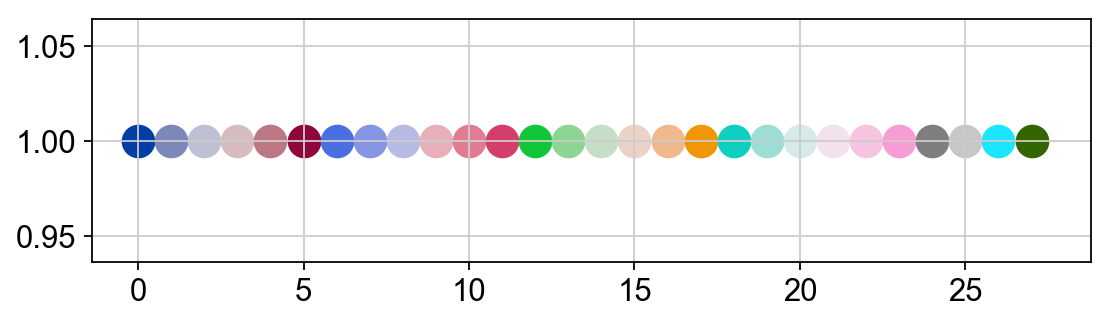

In [24]:
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [25]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = np.array(adata.uns['louvain_anno_colors'])

In [26]:
new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

In [27]:
adata.uns['louvain_anno_colors'] = new_colors

And add some white space to some cluster names. The layout shown here differs from the one in the paper, which can be found [here](https://github.com/theislab/paga/blob/f53fcdf4a861b7d3410f8096ffc13a07f1d225c0/blood/paul15/paul15.ipynb). These differences, however, are only cosmetic. We had to change the layout as we moved from a randomized PCA and float32 to float64 precision.

--> added 'pos', the PAGA positions (adata.uns['paga'])
saving figure to file ./figures/paga_compare.pdf


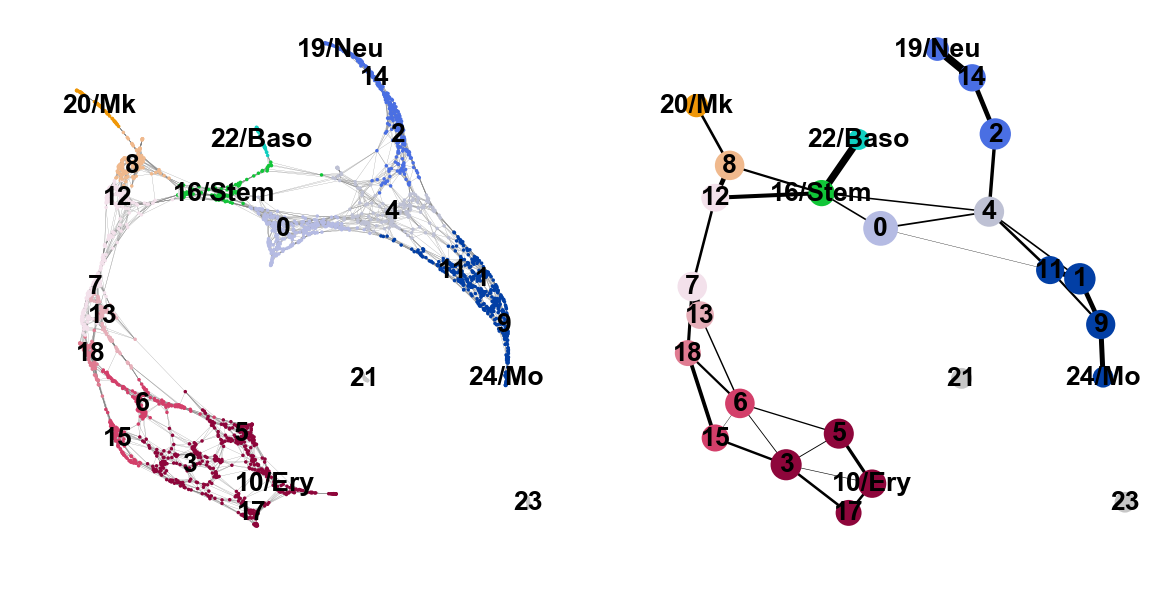

In [28]:
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

## Reconstructing gene changes along PAGA paths for a given set of genes

Choose a root cell for diffusion pseudotime.

In [29]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [30]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.00) --> added
    'dpt_pseudotime', the pseudotime (adata.obs)


Select some of the marker gene names.

In [31]:
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

Use the full raw data for visualization.

In [32]:
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical


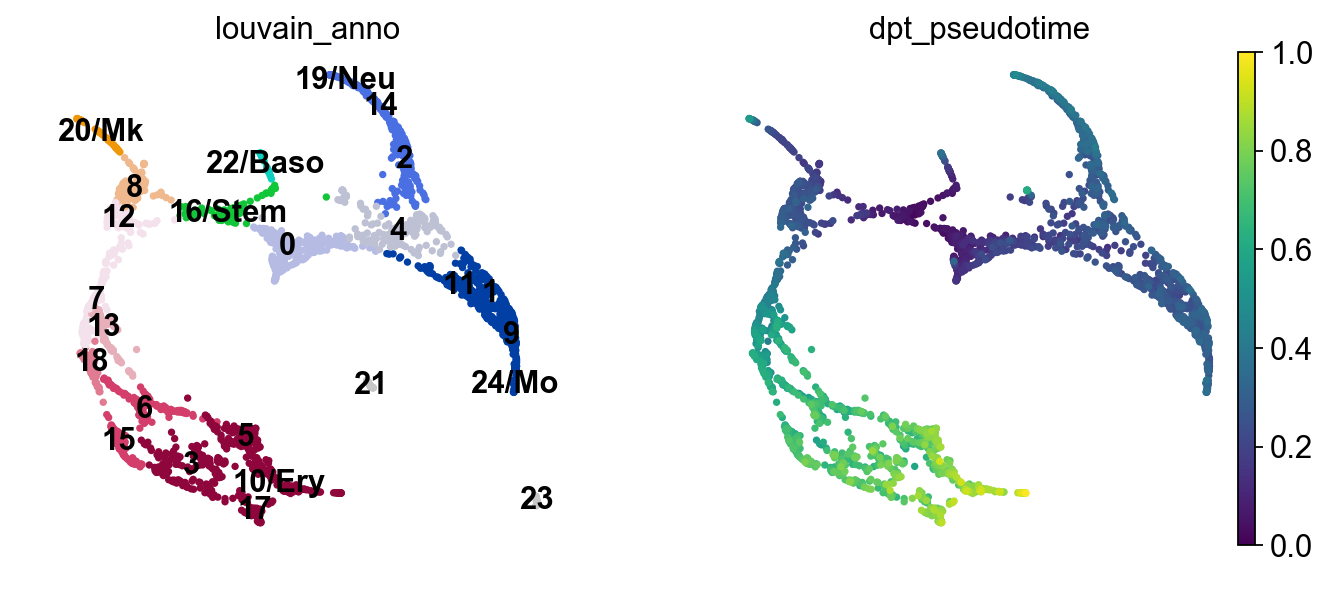

In [33]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [34]:
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [35]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']

In [36]:
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change

In [37]:
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [39]:
!mkdir write

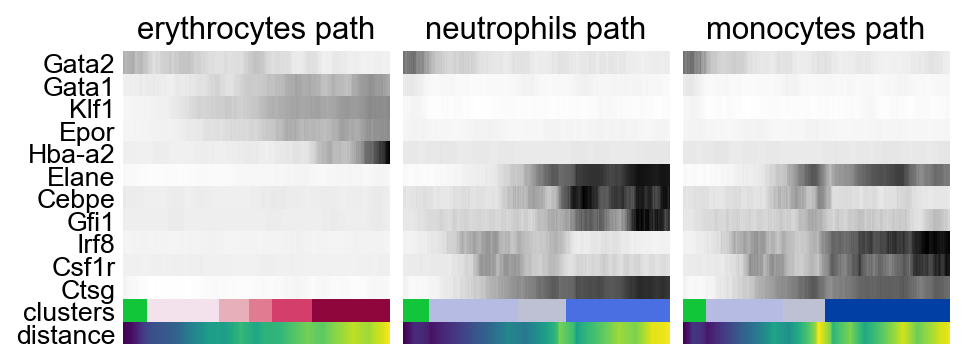

In [40]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,                         
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()